## Import dos dados e das bibliotecas

In [0]:
!wget -q https://raw.githubusercontent.com/BrunoGomesCoelho/doodling-network/master/Prova1/iris.data

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

TESTING = False

## Classe que representa uma MLP

Implementado de uma maneira vetorizada por mini batch. 

In [0]:
class MLP(): 
    def __init__(self, dimensions=[], momentum=0.9, classification=True, 
                 lr=0.1, testing=False, use_relu=False):
        self.lr = lr
        self.velocities = []
        self.momentum = momentum
        self.classification = classification
        
        # Initialize fully connected layers
        self.layers = []
        for idx, (input_dim, output_dim) in enumerate(dimensions, 1):
            self.layers.append(self.Linear(input_dim, output_dim))
            # For each linear layer, add a velocity term starting at 0
            self.velocities.append(np.zeros((input_dim, output_dim)))
            if idx != len(dimensions):
                if use_relu:
                    self.layers.append(self.ReLU())
                else:
                    self.layers.append(self.Sigmoid())
            else: # Last layer
                if self.classification:
                    self.layers.append(self.Softmax()) # for the last use softmax
            
        if classification:
            self.cost = self.CrossEntropy()
        else:
            self.cost = self.SquareLoss()
        
    class Sigmoid():
        def forward(self, x):
            # Cip the sigmoid to avoid overflow
            # See https://stackoverflow.com/questions/23128401/overflow-error-in-neural-networks-implementation
            clipped_x = np.clip(x, -500, 500)
            self.old_y = np.exp(clipped_x) / (1. + np.exp(clipped_x))
            return self.old_y

        def backward(self, grad):
            return self.old_y * (1. - self.old_y) * grad

    class Softmax():
        def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

        def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

    class CrossEntropy():
        def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

        def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)
    
    class Linear():
        def __init__(self,n_in,n_out):
            self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
            self.biases = np.zeros(n_out)

            self.w_vel = np.zeros((n_in,n_out))
            self.b_vel = np.zeros(n_out)

        def update_velocity(self, w_vel, b_vel):
            self.w_vel = w_vel
            self.b_vel = b_vel

        def forward(self, x):
            self.old_x = x
            return np.dot(x,self.weights) + self.biases

        def backward(self,grad):
            self.grad_b = grad.mean(axis=0)
            self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
            return np.dot(grad,self.weights.transpose())

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
            
    def fit(self, x, y, n_iter=100, mini_batch=32):
        for _ in range(n_iter):   
            total_loss = 0
            for start_idx in range(0, len(x), mini_batch):
                x_batch = x[start_idx:start_idx+mini_batch]
                y_batch = y[start_idx:start_idx+mini_batch]   
                
                # Forward and backward
                loss = self.loss(x_batch,y_batch)
                total_loss += loss.sum()
                self.backward()
                
                # Update according to momentum
                for layer in self.layers:
                    if type(layer) == self.Linear:
                        new_w_vel = self.momentum*layer.w_vel - self.lr*layer.grad_w
                        new_b_vel = self.momentum*layer.b_vel - self.lr*layer.grad_b
                        
                        layer.weights += new_w_vel
                        layer.weights += new_b_vel
                        
                        layer.update_velocity(new_w_vel, new_b_vel)

    def predict(self, x):
        output = self.forward(x)
        if self.classification:
            return output.argmax(axis=-1)                       
        else:
            return output

## Classe que representa uma RBF

Implementado de uma maneira vetorizada por mini batch. 

Primeiro vamos definir a função gaussiana:

In [0]:
def gaussian(X, centroid, sigma=1):
    norm = np.linalg.norm(X-centroid.values, axis=1)
    #mult = -1 / (2*sigma**2)
    # Utilizamos um valor diferente de 1 para visualizar no plot, 
    #    caso contrário o desenho não aparece no gráfico
    mult = 1/8 #-1 / (2*sigma**2)
    return np.exp(mult*norm**2)

Agora sim a nossa RBF que chama uma MLP simples por trás:

In [0]:
class RBF(): 
    def __init__(self, centroids, input_size=2, output_size=3, lr=0.1, 
                 testing=False):
        self.lr = lr
        self.mlp = MLP(dimensions=[(input_size, output_size)], momentum=0,
                      classification=True, lr=lr, testing=testing)
        
        # Initialize fully connected layers
        self.centroids = centroids
        self.rbf = gaussian
           
    def rbf_layer(self, x):
        """Converts our x matrix, where each row is a example and each column a feature,
        into a new matrix where each row is a example and each columm a
        RBF function with a different centroid."""
        new_x = np.zeros((x.shape[0], len(self.centroids)))
        
        for idx, centroid in self.centroids.iterrows():
            new_x[:, idx-1] = self.rbf(x, centroid, self.sigma)
        return new_x

    def fit(self, x, y, n_iter=100, mini_batch=32):
        # Calculate the centroids and sigma
        self.sigma = 1
        
        # Go through the RBF layer
        new_x = self.rbf_layer(x)
        new_y = pd.get_dummies(y).values
        
        # Call the 1 layer MLP
        self.mlp.fit(new_x, new_y, n_iter=n_iter)
                
    def predict(self, x):
        new_x = self.rbf_layer(x)
        output = self.mlp.forward(new_x)
        return output.argmax(axis=-1)                       



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Funções auxiliares

Diversas funções que seram utilizadas para ambos os datasets

Função para carregar os dados

In [0]:
def load_and_analyze(filename, target, header=0):
    df = pd.read_csv(filename, header=header)
    df.columns = ["sepal length", "sepal width", "petal length", 
                  "petal width", "class"]
    # Check for nulls
    print(f"Temos {df.isna().sum().sum()} nulos na nossa tabela")
    
    x = df.drop(columns=[target])
    y = df[target]
    return x, y



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# 1a Questão: Plotar o conjunto iris.data considerando apenas dois atributos: sepal width e sepal length.

Temos 0 nulos na nossa tabela


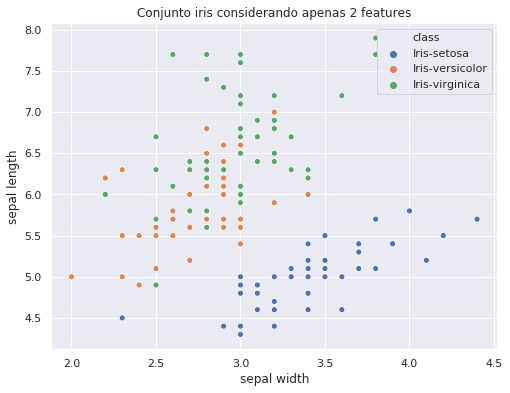

In [177]:
# Load data and create encoding
x, y = load_and_analyze("iris.data", target="class", header=None)
label_enc = LabelEncoder()
label_enc.fit(y)

def plot_data(x, y, hue, title="Conjunto iris considerando apenas 2 features"):
    # Plot data
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, hue=hue)
    plt.title(title);

plot_data(x["sepal width"], x["sepal length"], y)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>



Função  para normalizar os dados que vamos utilizar posteriormente

In [0]:
def normalize_data(x_train, x_test, y=None, pandas=True):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(x_train)

Função para rodar 1 experimento

In [0]:
def run_experiment(x, y, model, test_percent=0.3, n_iter=100):
    # Train test split
    x_norm = normalize_data(x, None)
    old_y = y.copy(deep=True)
    y = pd.get_dummies(y)

    # Train 
    #model.fit(x_train.values, y_train.values, n_iter=n_iter)
    #linear1 = model.layers[0].forward(x_test)
    model.fit(x_norm, y.values, n_iter=n_iter)
    linear1 = model.layers[0].forward(x_norm)
    sigmoid1 = model.layers[1].forward(linear1)
    return old_y, sigmoid1



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# 2ª. Questão: Construa  uma rede MLP com 4 neuronios na cam. de entrada,3 neurôniosna  camada  de  saída  e 2  neurônios  na  camada  intermediaria.  Utilize como função de ativação a função sigmóide, em ambas as camadas. Salvar as saídas da cam. Intermediária depois do treinamento

In [0]:
mlp = MLP(dimensions=[(4, 2), (2, 3)], momentum=0, lr=0.1, 
          use_relu=False)

In [0]:
n_iter = 1000
y_test, sigmoid_output = run_experiment(x, y, mlp, n_iter=n_iter)


<br>
<br>
<br>

# a) Plotar o    conjunto    de    dados    transformado    obtidos    na    cam. intermediaria

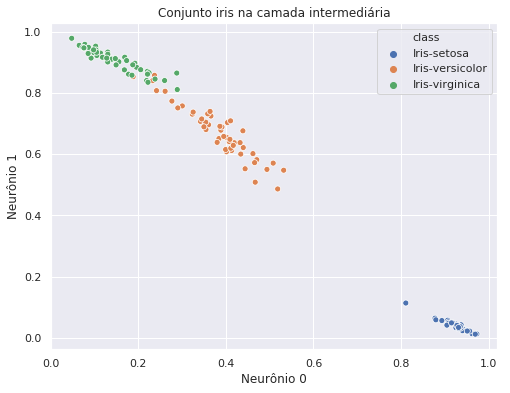

In [182]:
plot_data(sigmoid_output[:, 0], sigmoid_output[:, 1], y_test,
          title="Conjunto iris na camada intermediária")
plt.xlabel("Neurônio 0")
plt.ylabel("Neurônio 1");


<br>
<br>
<br>

# b) O que pode ser observado da aplicação da função sigmoidal?

A função sigmoidal coloca as nossas saídas entre 0 e 1, e de fato consegue dividir as classes muito bem no espaço, embora o problema inicial seja não linearmente dividido.

Ou seja, de fato a representação intermediária que foi aprendida conseguiu mover os dados no espaço de uma maneira não linear melhor do que a combinação inicial de 2 features.



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# 3ª. Questão: Utilizar uma função de base radial (Gaussiana) nos neurônios da camada intermediária para classificar o conjunto de dados disponibilizado. Por questões  de  visualização,  usar  2  neurônios  na  cam.  intermediaria,  isto  é,  a mesma topologia da questão anterior, embora deveria ser 3 neuronios uma vez que temos 3 classes no conj. iris.dat. Determinar o centro de cada grupo, usando algum  método adequado. Deverão ser encontrados 2 centroides apenas.Adote largura igual a 1 para  todos os  grupos. Salvar as saídas da cam.  intermediária depois do treinamento. 

Vamos utilizar o centroide das classes "iris setosa" como um centro, e o outro como o centro das outras 2 classes juntas


In [214]:
centroids = x.groupby(y != "Iris-virginica").mean()
rbf = RBF(centroids) 

x_norm = normalize_data(x, None)
rbf.fit(x_norm, y.values, n_iter=n_iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


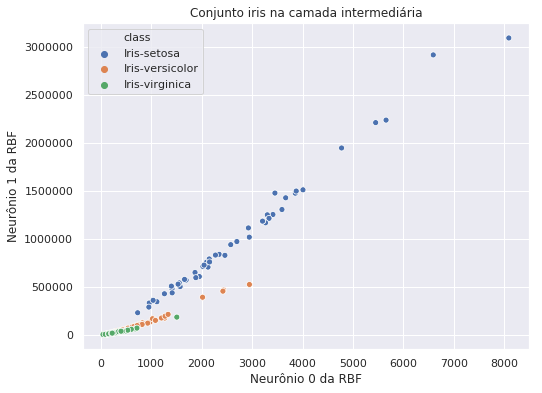

In [215]:
rbf_output = rbf.rbf_layer(x_norm)
max0 = 1.0
max1 = 1.0

plot_data(rbf_output[:, 0]*max0, rbf_output[:, 1]*max1, y_test,
          title="Conjunto iris na camada intermediária")
plt.xlabel("Neurônio 0 da RBF")
plt.ylabel("Neurônio 1 da RBF");

Conforme podemos observar, a RBF também conseguiu mapear os dados para um outro espaço de uma maneira que uma separação linear fica mais fácil.

É interessante observar que utilizamos um valor diferente de sigma do que o 1, para poder visualizar os dados no gráfico - embora o valor de sigma = 1 também separe, ele dificulta a visualização.
